## Traininig of the High Level Feature classifier using XGBoost on GPU

**XGBoost** This notebook trains a particle classifier using High Level Features. It uses XGBoost. Pandas is used to read the data and pass it to XGBoost.  

Credits: this notebook is part of the work: 
- [Machine Learning Pipelines with Modern Big Data Tools for High Energy Physics Comput Softw Big Sci 4, 8 (2020)](https://rdcu.be/b4Wk9)  
- Code and data at:https://github.com/cerndb/SparkDLTrigger
- The model is a classifier implemented as a DNN
  - Model input: 14 "high level features", described in [ Topology classification with deep learning to improve real-time event selection at the LHC](https://link.springer.com/epdf/10.1007/s41781-019-0028-1?author_access_token=eTrqfrCuFIP2vF4nDLnFfPe4RwlQNchNByi7wbcMAY7NPT1w8XxcX1ECT83E92HWx9dJzh9T9_y5Vfi9oc80ZXe7hp7PAj21GjdEF2hlNWXYAkFiNn--k5gFtNRj6avm0UukUt9M9hAH_j4UR7eR-g%3D%3D)
  - Model output: 3 classes, "W + jet", "QCD", "$t\bar{t}$"


## Load train and test datasets via Pandas

In [1]:
# Download the datasets from 
# https://github.com/cerndb/SparkDLTrigger/tree/master/Data
#
# For CERN users, data is already available on EOS
PATH = "/eos/project/s/sparkdltrigger/public/"

import pandas as pd

testPDF = pd.read_parquet(path= PATH + 'testUndersampled_HLF_features.parquet', 
                          columns=['HLF_input', 'encoded_label'])

trainPDF = pd.read_parquet(path= PATH + 'trainUndersampled_HLF_features.parquet', 
                           columns=['HLF_input', 'encoded_label'])

In [2]:
# Check the number of events in the train and test datasets

num_test = testPDF.count()
num_train = trainPDF.count()

print('There are {} events in the test dataset'.format(num_test))
print('There are {} events in the train dataset'.format(num_train))

There are HLF_input        856090
encoded_label    856090
dtype: int64 events in the test dataset
There are HLF_input        3426083
encoded_label    3426083
dtype: int64 events in the train dataset


In [3]:
# Show the schema and a data sample of the test dataset
testPDF


,HLF_input,encoded_label
0,"[0.015150733133517018, 0.003511028294205839, 0...","[1.0, 0.0, 0.0]"
1,"[0.0, 0.003881822832783805, 0.7166341448458555...","[1.0, 0.0, 0.0]"
2,"[0.009639073600865505, 0.0010022659022912096, ...","[1.0, 0.0, 0.0]"
3,"[0.016354407625436572, 0.002108937905084598, 0...","[1.0, 0.0, 0.0]"
4,"[0.01925979125354152, 0.004603697276827594, 0....","[1.0, 0.0, 0.0]"
...,...,...
856085,"[0.020383967386165446, 0.0022348975484913444, ...","[0.0, 1.0, 0.0]"
856086,"[0.02475209699743233, 0.00867502196073073, 0.3...","[0.0, 1.0, 0.0]"
856087,"[0.03498179428310887, 0.02506331737284528, 0.9...","[0.0, 1.0, 0.0]"
856088,"[0.03735147362869153, 0.003645269183639405, 0....","[0.0, 1.0, 0.0]"


## Convert training and test datasets from Pandas DataFrames to Numpy arrays

Now we will collect and convert the Pandas DataFrame into numpy arrays in order to be able to feed them to TensorFlow/Keras.


In [4]:
import numpy as np

X = np.stack(trainPDF["HLF_input"])
y = np.stack(trainPDF["encoded_label"])

X_test = np.stack(testPDF["HLF_input"])
y_test = np.stack(testPDF["encoded_label"])

## XGBoost

In [5]:
import xgboost
from xgboost import XGBClassifier

xgboost.__version__

'1.7.3'

In [6]:
# Create model instance
# Use XGBoost on GPU resources
#bst = XGBClassifier(tree_method='gpu_hist', n_estimators=3, max_depth=2, learning_rate=1, objective='multi:softprob')

bst =  XGBClassifier(tree_method='gpu_hist')


In [7]:
# Train the model on the training dataset
%time bst.fit(X, y)

CPU times: user 9.47 s, sys: 5.14 s, total: 14.6 s
Wall time: 14.4 s


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

## Evaluate the Classifier - Performance metrics

In [8]:
# make predictions
y_pred =  preds = bst.predict(X_test)

In [9]:
from sklearn.metrics import accuracy_score

print('Accuracy of the HLF classifier: {:.4f}'.format(
    accuracy_score(np.argmax(y_test, axis=1),np.argmax(y_pred, axis=1))))

Accuracy of the HLF classifier: 0.9170


/tmp/ipykernel_6259/361990750.py:12: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  cm = cm / cm.astype(np.float).sum(axis=1)


<IPython.core.display.Javascript object>


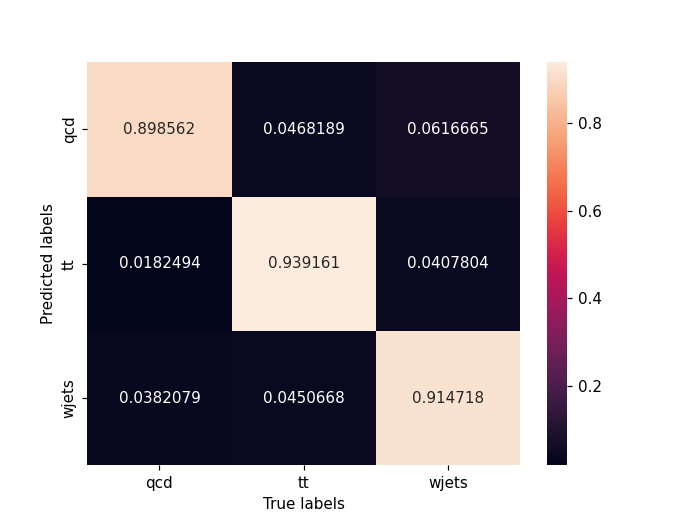

In [10]:
%matplotlib notebook

import matplotlib.pyplot as plt 
import seaborn as sns
from sklearn.metrics import confusion_matrix
labels_name = ['qcd', 'tt', 'wjets']
labels = [0,1,2]

cm = confusion_matrix(np.argmax(y_pred, axis=1), np.argmax(y_test, axis=1), labels=labels)

## Normalize CM
cm = cm / cm.astype(np.float).sum(axis=1)

fig, ax = plt.subplots()
ax = sns.heatmap(cm, annot=True, fmt='g')
ax.xaxis.set_ticklabels(labels_name)
ax.yaxis.set_ticklabels(labels_name)
plt.xlabel('True labels')
plt.ylabel('Predicted labels')
plt.show()

## ROC and AUC

In [11]:
from sklearn.metrics import roc_curve, auc

fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(3):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

In [12]:
# Dictionary containign ROC-AUC for the three classes 
roc_auc

{0: 0.944642574853839, 1: 0.9413292411994327, 2: 0.9303572619556151}

<IPython.core.display.Javascript object>


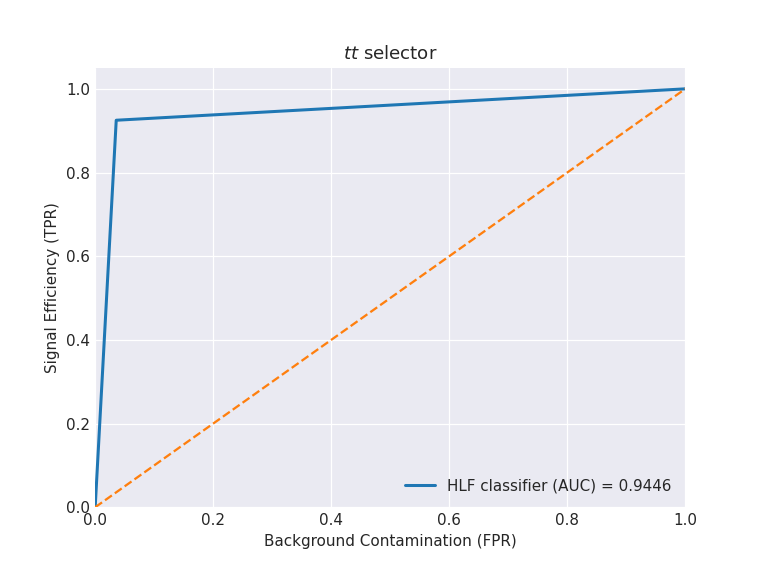

In [17]:
%matplotlib notebook

# Plot roc curve 
import matplotlib.pyplot as plt
plt.style.use('seaborn-darkgrid')

plt.figure()
plt.plot(fpr[0], tpr[0], lw=2, \
         label='HLF classifier (AUC) = %0.4f' % roc_auc[0])
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Background Contamination (FPR)')
plt.ylabel('Signal Efficiency (TPR)')
plt.title('$tt$ selector')
plt.legend(loc="lower right")
plt.show()